# $\mathrm{CH_3OOH}$ (Methylhydroperoxide)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3OOH" 
nice_name = "Methylhydroperoxide"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println(unique(T1s))

[295.0, 298.0, 297.0, 294.0]


In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

2025


4×7 DataFrame
 Row │ variable   mean           min          median      max         nmissing ⋯
     │ Symbol     Float64        Real         Float64     Real        Int64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ          577.341        205.99       614.41      638.254            0 ⋯
   2 │ σ            6.74099e-21    1.012e-25    6.33e-25    3.75e-19         0
   3 │ T          297.891        294.0        298.0       298.0              0
   4 │ source_id    8.70815        1            9.0        14                0
                                                                1 column omitted

In [8]:
#idxs_298 = [i for i ∈ 1:size(T1s, 1) if T1s[i] == 298.0]
#unique(source_idx[idxs_298])
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

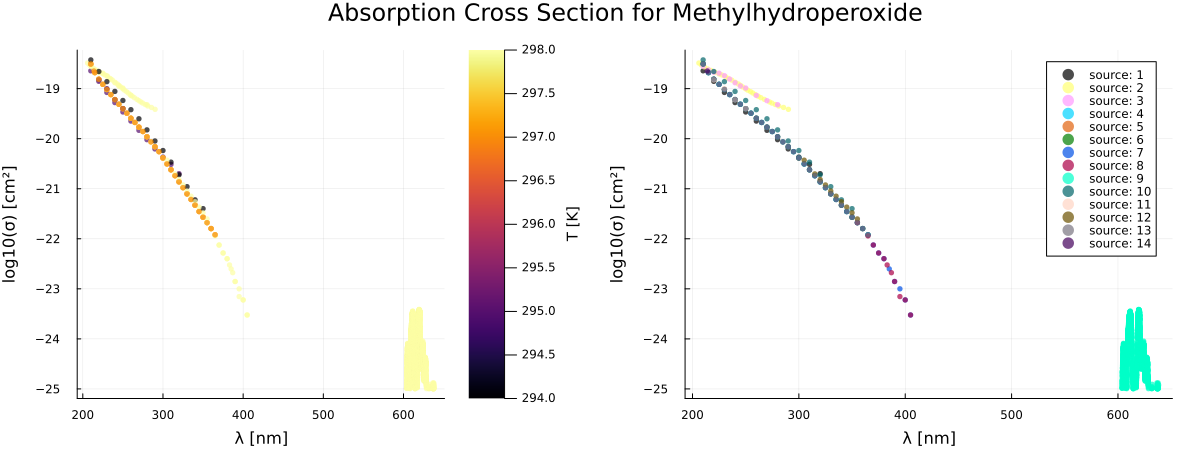

In [9]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        log10.(df_g.σ[1:nskip:end]),
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="log10(σ) [cm²]",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Absorption Cross Section for $(nice_name)",)

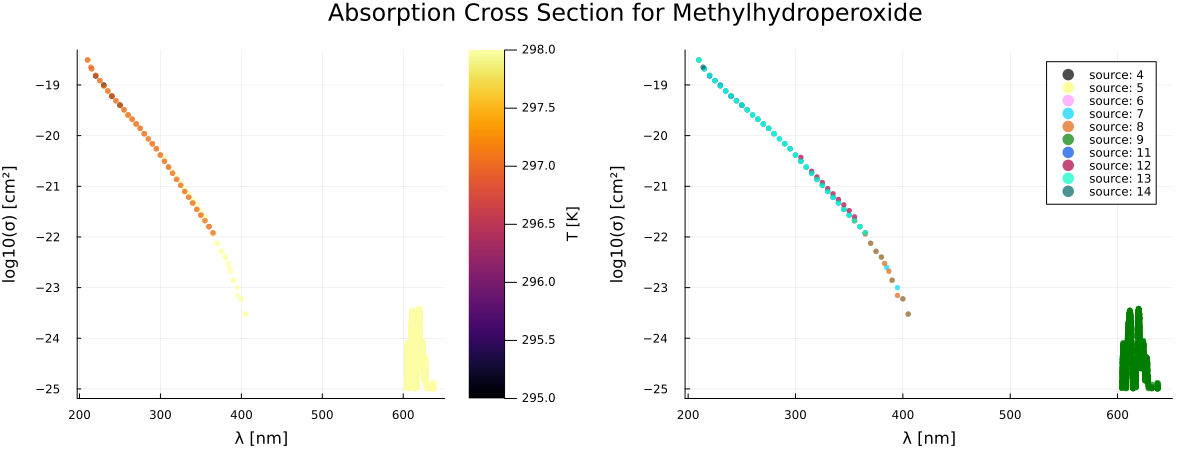

In [10]:
# let's drop source 2 and 3
df = df[df.source_id .!= 1 .&& df.source_id .!= 2 .&& df.source_id .!= 3 .&& df.source_id .!= 10, :]


p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        log10.(df_g.σ[1:nskip:end]),
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="log10(σ) [cm²]",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Absorption Cross Section for $(nice_name)",)

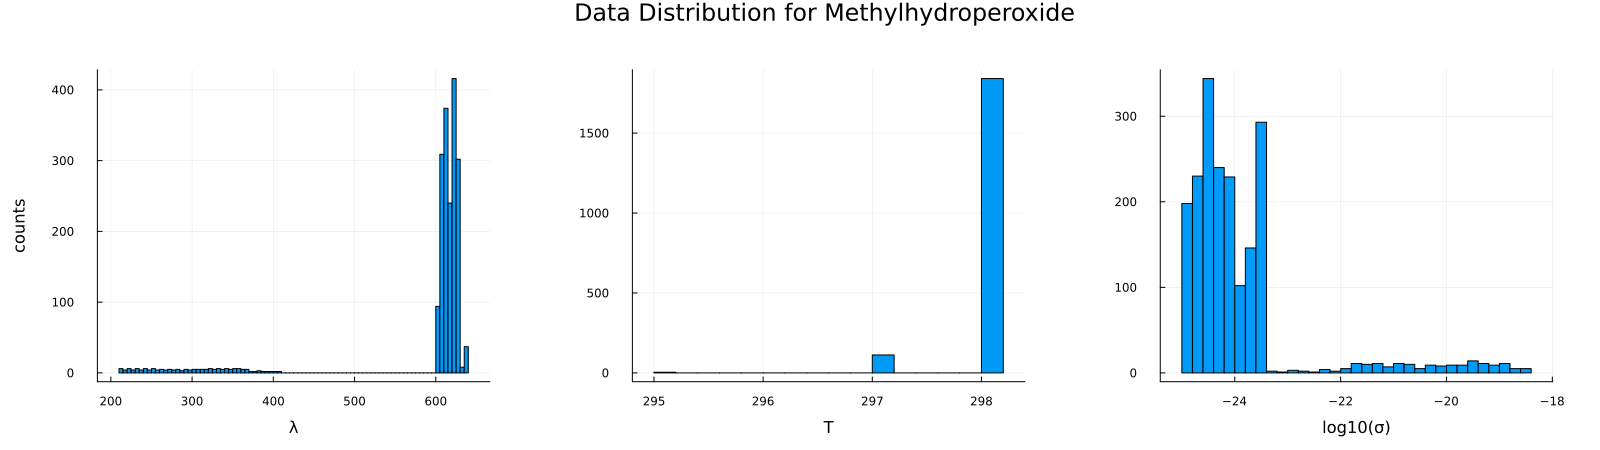

In [11]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [12]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [13]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [14]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

1859×3 DataFrame
  Row │ λ        σ          T       
      │ Float64  Float64    Float64 
──────┼─────────────────────────────
    1 │ 220.0    1.5e-19      295.0
    2 │ 230.0    1.0e-19      295.0
    3 │ 240.0    6.0e-20      295.0
    4 │ 250.0    4.0e-20      295.0
    5 │ 210.0    3.12e-19     297.0
    6 │ 215.0    2.09e-19     297.0
    7 │ 220.0    1.54e-19     297.0
    8 │ 225.0    1.22e-19     297.0
    9 │ 230.0    9.62e-20     297.0
   10 │ 235.0    7.61e-20     297.0
   11 │ 240.0    6.05e-20     297.0
  ⋮   │    ⋮         ⋮         ⋮
 1850 │ 637.534  1.053e-25    298.0
 1851 │ 637.57   1.012e-25    298.0
 1852 │ 637.654  1.012e-25    298.0
 1853 │ 637.702  1.012e-25    298.0
 1854 │ 637.726  1.093e-25    298.0
 1855 │ 637.774  1.318e-25    298.0
 1856 │ 637.786  1.032e-25    298.0
 1857 │ 637.93   1.032e-25    298.0
 1858 │ 637.99   1.114e-25    298.0
 1859 │ 638.254  1.195e-25    298.0
                   1838 rows omitted

For whatever reason, the fit doesn't work with both ranges. So I'm just going to combine two separate fits

In [15]:
# df_unique = filter_outliers(df_unique, log10.(df_unique.σ); frac=5)
# println(nrow(df_unique))

#df_unique = df_unique[df_unique.T .== 298.0, :]
df_unique1 = df_unique[df_unique.λ .< 500.0, :]
df_unique2 = df_unique[df_unique.λ .> 500.0, :]


1780×3 DataFrame
  Row │ λ        σ          T       
      │ Float64  Float64    Float64 
──────┼─────────────────────────────
    1 │ 603.856  1.053e-25    298.0
    2 │ 603.88   1.053e-25    298.0
    3 │ 603.892  1.032e-25    298.0
    4 │ 603.916  1.032e-25    298.0
    5 │ 603.928  1.318e-25    298.0
    6 │ 603.94   1.338e-25    298.0
    7 │ 603.952  1.216e-25    298.0
    8 │ 603.964  1.256e-25    298.0
    9 │ 603.976  1.134e-25    298.0
   10 │ 603.988  1.195e-25    298.0
   11 │ 604.0    1.114e-25    298.0
  ⋮   │    ⋮         ⋮         ⋮
 1771 │ 637.534  1.053e-25    298.0
 1772 │ 637.57   1.012e-25    298.0
 1773 │ 637.654  1.012e-25    298.0
 1774 │ 637.702  1.012e-25    298.0
 1775 │ 637.726  1.093e-25    298.0
 1776 │ 637.774  1.318e-25    298.0
 1777 │ 637.786  1.032e-25    298.0
 1778 │ 637.93   1.032e-25    298.0
 1779 │ 637.99   1.114e-25    298.0
 1780 │ 638.254  1.195e-25    298.0
                   1759 rows omitted

In [16]:
df_sampled1 = df_unique1
df_sampled2 = df_unique2


1780×3 DataFrame
  Row │ λ        σ          T       
      │ Float64  Float64    Float64 
──────┼─────────────────────────────
    1 │ 603.856  1.053e-25    298.0
    2 │ 603.88   1.053e-25    298.0
    3 │ 603.892  1.032e-25    298.0
    4 │ 603.916  1.032e-25    298.0
    5 │ 603.928  1.318e-25    298.0
    6 │ 603.94   1.338e-25    298.0
    7 │ 603.952  1.216e-25    298.0
    8 │ 603.964  1.256e-25    298.0
    9 │ 603.976  1.134e-25    298.0
   10 │ 603.988  1.195e-25    298.0
   11 │ 604.0    1.114e-25    298.0
  ⋮   │    ⋮         ⋮         ⋮
 1771 │ 637.534  1.053e-25    298.0
 1772 │ 637.57   1.012e-25    298.0
 1773 │ 637.654  1.012e-25    298.0
 1774 │ 637.702  1.012e-25    298.0
 1775 │ 637.726  1.093e-25    298.0
 1776 │ 637.774  1.318e-25    298.0
 1777 │ 637.786  1.032e-25    298.0
 1778 │ 637.93   1.032e-25    298.0
 1779 │ 637.99   1.114e-25    298.0
 1780 │ 638.254  1.195e-25    298.0
                   1759 rows omitted

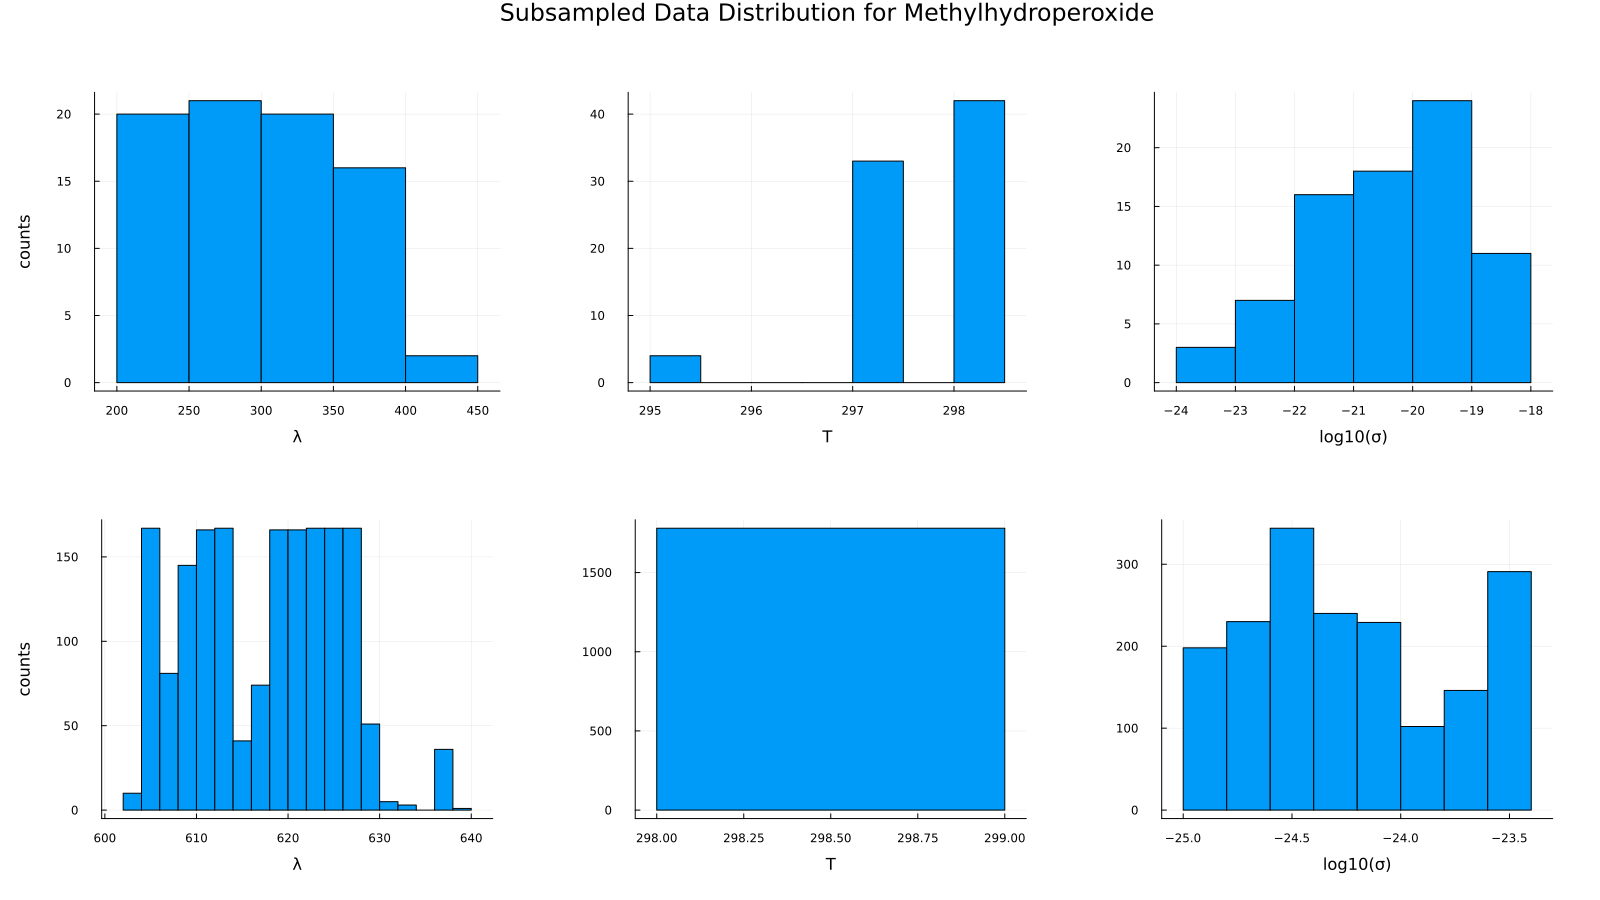

In [17]:
p1 = histogram(df_sampled1.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled1.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled1.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)


p4 = histogram(df_sampled2.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p5 = histogram(df_sampled2.T, xlabel="T", label="", margin=10Plots.mm)
p6 = histogram(log10.(df_sampled2.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)

#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist1 = plot(p1, p2, p3, layout=(1,3))
phist2 = plot(p4, p5, p6, layout=(1,3))
plot(phist1, phist2, layout=(2,1), size=(1600, 900), plot_title="Subsampled Data Distribution for $(nice_name)")

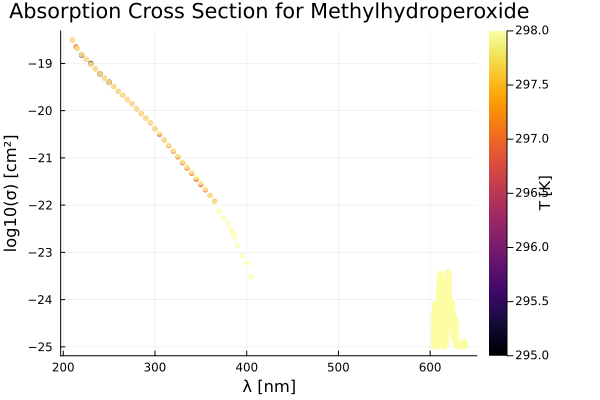

In [18]:
p = scatter(
    df_sampled1.λ,
    log10.(df_sampled1.σ),
    zcolor=df_sampled1.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

scatter!(
    df_sampled2.λ,
    log10.(df_sampled2.σ),
    zcolor=df_sampled2.T,
    ms=3, 
    msw=0,
    alpha=0.7,
    label="",
)

# GPR Fit

In [49]:
train_frac = 0.9
ntrain1 = trunc(Int, train_frac * nrow(df_sampled1))
ntrain2 = trunc(Int, train_frac * nrow(df_sampled2))
println(ntrain1)
println(ntrain2)

71
1602


In [50]:
idxs = shuffle(1:nrow(df_sampled1))
idxs_train = idxs[1:ntrain1]
idxs_test = idxs[ntrain1+1:end]

Xtrain1 = df_sampled1[idxs_train, [:λ, :T]]
Xtest1 = df_sampled1[idxs_test, [:λ, :T]]

ytrain1 = log10.(df_sampled1.σ[idxs_train])
ytest1 = log10.(df_sampled1.σ[idxs_test])


idxs = shuffle(1:nrow(df_sampled2))
idxs_train = idxs[1:ntrain2]
idxs_test = idxs[ntrain2+1:end]

Xtrain2 = df_sampled2[idxs_train, [:λ, :T]]
Xtest2 = df_sampled2[idxs_test, [:λ, :T]]

ytrain2 = log10.(df_sampled2.σ[idxs_train])
ytest2 = log10.(df_sampled2.σ[idxs_test])

178-element Vector{Float64}:
 -24.18621892182592
 -23.877456475931247
 -24.662940273679475
 -23.790216985151485
 -24.510041520575164
 -24.77365791283637
 -24.47430747549499
 -24.74304184743907
 -23.69058277422186
 -24.52157781225992
 -24.200039472594018
 -23.99567862621736
 -23.47249898901888
   ⋮
 -24.639028116274066
 -24.153539174870666
 -24.55846196129784
 -24.441291429466833
 -24.463820467862774
 -23.559090917934782
 -23.778325002929233
 -24.443697499232712
 -23.628378072823978
 -24.129011186239424
 -24.441291429466833
 -24.530472520812985

In [51]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain1.λ)/κ
ℓ_T = std(Xtrain1.T)/κ
println("ℓ_λ: ",ℓ_λ)
println("ℓ_T: ",ℓ_T)


# compute variance parameters
SNR = 200.0
σf² = 10*(var(ytrain1))
σₙ² = (sqrt(σf²)/SNR)^2
println("σf²: ", σf²)
println("σₙ²: ", σₙ²)

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

ℓ_λ: 56.83912859320956
ℓ_T: 0.7667643480185774
σf²: 17.169504745378095
σₙ²: 0.00042923761863445243


mykernel (generic function with 1 method)

In [52]:
μ_init = -30.0
gpr1 = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.8431348294425094, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.040224971976761, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.26557578282383615, exp, 1.4901161193847656e-8)), 
  σ² = 0.00042923761863445243, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [53]:
mach1 = machine(gpr1, Xtrain1, ytrain1) |> fit!

Iter     Function value   Gradient norm 
     0    -9.867498e+01     4.340615e+01
 * time: 6.508827209472656e-5
     1    -1.112502e+02     3.440864e+01
 * time: 0.005113124847412109
     2    -1.179643e+02     3.698359e+01
 * time: 0.008613109588623047
     3    -1.206953e+02     9.000305e+00
 * time: 0.01433110237121582
     4    -1.273337e+02     8.018792e+00
 * time: 0.054267168045043945
     5    -1.424926e+02     4.340715e+01
 * time: 0.06154012680053711
     6    -1.466222e+02     4.560689e+00
 * time: 0.06995296478271484
     7    -1.470023e+02     1.876612e+00
 * time: 0.07827496528625488
     8    -1.476765e+02     1.641760e+00
 * time: 0.09016895294189453
     9    -1.481693e+02     5.037623e+00
 * time: 0.10125613212585449
    10    -1.488759e+02     7.050145e+00
 * time: 0.11005496978759766
    11    -1.496089e+02     9.572999e+00
 * time: 0.11362004280090332
    12    -1.509538e+02     8.115447e-01
 * time: 0.11825108528137207
    13    -1.510851e+02     1.459787e+00
 * t

[ Info: Training machine(GPR(μ = -30.0, …), …).


trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @086 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @070 ⏎ AbstractVector{Continuous}


In [58]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain2.λ)/κ
ℓ_T = 0.1 # std(Xtrain2.T)/κ
println("ℓ_λ: ",ℓ_λ)
println("ℓ_T: ",ℓ_T)


# compute variance parameters
SNR = 5.0
σf² = 2*(var(ytrain2))
σₙ² = (sqrt(σf²)/SNR)^2
println("σf²: ", σf²)
println("σₙ²: ", σₙ²)

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

# overwriting with previous best-fit values
θ_init = (σf²=positive(12.618791223254764), ℓ_λ=positive(0.9560502182133316), ℓ_T=positive(0.10002067605255963))
σₙ² = 0.0012585163053439883


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

ℓ_λ: 8.010867887862942
ℓ_T: 0.1
σf²: 0.43451210222856645
σₙ²: 0.01738048408914266


mykernel (generic function with 1 method)

In [59]:
μ_init = -30.0
gpr2 = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.535187068718342, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.044944853384679226, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.3023785028212806, exp, 1.4901161193847656e-8)), 
  σ² = 0.0012585163053439883, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [60]:
mach2 = machine(gpr2, Xtrain2, ytrain2) |> fit!

Iter     Function value   Gradient norm 
     0    -2.790265e+03     4.019748e+01
 * time: 5.602836608886719e-5
     1    -2.791181e+03     2.122528e+01
 * time: 1.7287800312042236
     2    -2.791282e+03     1.470572e+00
 * time: 2.4413950443267822
     3    -2.791286e+03     5.154189e-02
 * time: 3.2724101543426514
     4    -2.791283e+03     1.990652e-02
 * time: 4.97015905380249
     5    -2.791280e+03     1.785353e-02
 * time: 6.449839115142822
     6    -2.791288e+03     3.176755e-02
 * time: 7.4048850536346436
     7    -2.791287e+03     3.165159e-02
 * time: 23.210787057876587
     8    -2.791288e+03     2.030420e-02
 * time: 25.70166802406311
     9    -2.791285e+03     2.860669e-02
 * time: 54.482314109802246
    10    -2.791284e+03     1.902960e-02
 * time: 55.56867694854736
    11    -2.791283e+03     1.196275e-02
 * time: 58.74242806434631
    12    -2.791282e+03     3.393701e-02
 * time: 60.986613035202026
    13    -2.791280e+03     2.943614e-02
 * time: 63.1739089488983

[ Info: Training machine(GPR(μ = -30.0, …), …).


trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @308 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @471 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [76]:
rpt1 = report(mach1)

(summary = "L-BFGS",
 minimizer = [4.204303931465178, 4.6001592339266075, 7.861623920185453, -8.073394821126614],
 minimum = -151.13311564643362,
 iterations = 150,
 converged = true,)

In [77]:
rpt2 = report(mach2)

(summary = "L-BFGS",
 minimizer = [2.5347783891405262, -0.0468594581399237, -2.302400755398375, -6.627152618226384],
 minimum = -2791.2804063449667,
 iterations = 14,
 converged = true,)

In [78]:
fp1 = fitted_params(mach1)

(θ_best = [:σf² => 66.97396298434089, :ℓ_λ => 99.5001581963519, :ℓ_T => 2595.7322165974733],
 σ² = 0.00031173813928244847,)

In [79]:
fp2 = fitted_params(mach2)

(θ_best = [:σf² => 12.613635234636574, :ℓ_λ => 0.9542215111320805, :ℓ_T => 0.10001845035985013],
 σ² = 0.0013239423522399354,)

In [80]:
y_pred_train1 = predict_mean(mach1, Xtrain1);
y_pred_test1 = predict_mean(mach1, Xtest1);

y_pred_train2 = predict_mean(mach2, Xtrain2);
y_pred_test2 = predict_mean(mach2, Xtest2);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


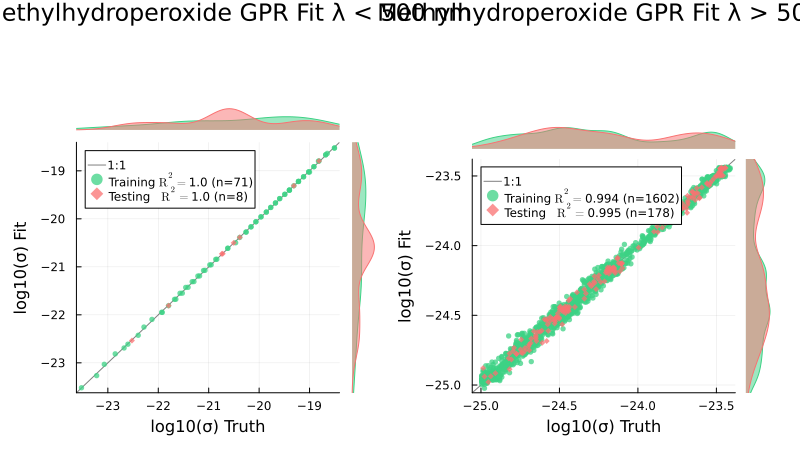

In [81]:
p = scatterresult(
    ytrain1, y_pred_train1,
    ytest1, y_pred_test1,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit λ < 500 nm"
)

p2 = scatterresult(
    ytrain2, y_pred_train2,
    ytest2, y_pred_test2,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit λ > 500 nm"
)

plot(p, p2, layout=(1,2), size=(800, 450), margins=5Plots.mm)

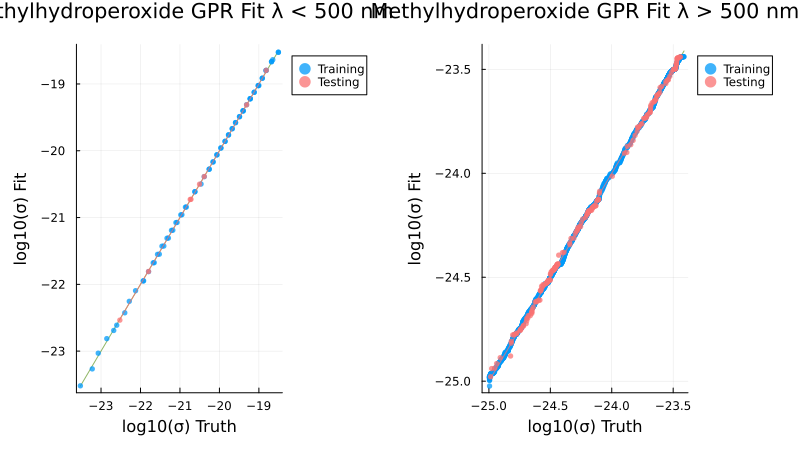

In [82]:
p = quantilequantile(
    ytrain1, y_pred_train1,
    ytest1, y_pred_test1,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit λ < 500 nm"
)


p2 = quantilequantile(
    ytrain2, y_pred_train2,
    ytest2, y_pred_test2,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit λ > 500 nm"
)

plot(p, p2, layout=(1,2), size=(800, 450), margins=5Plots.mm)

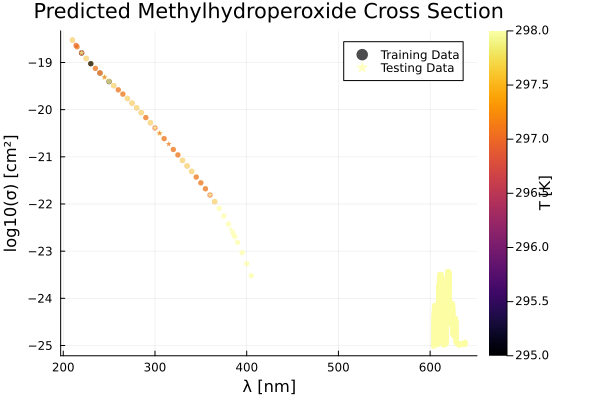

In [83]:
p1 = scatter(
    Xtrain1.λ,
    y_pred_train1,
    zcolor=Xtrain1.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest1.λ,
    y_pred_test1,
    zcolor=Xtest1.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


scatter!(
    Xtrain2.λ,
    y_pred_train2,
    zcolor=Xtrain2.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="",
)

scatter!(
    Xtest2.λ,
    y_pred_test2,
    zcolor=Xtest2.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="",
)


Finally, let's try prediction at the desired wavelength bins: 

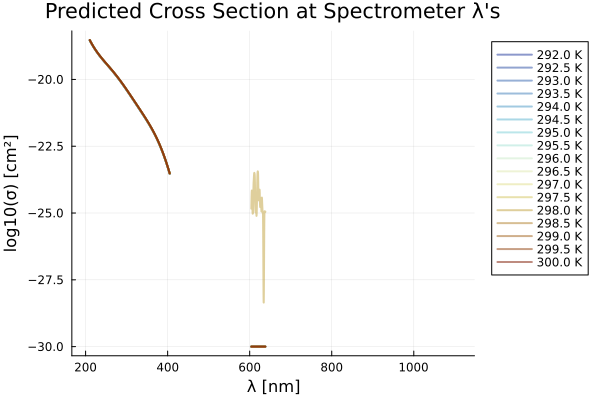

In [84]:
λ_min1 = maximum([minimum(df_sampled1.λ), minimum(hr4000_df.λ)])
λ_max1 = minimum([maximum(df_sampled1.λ), maximum(hr4000_df.λ)])

λ_min2 = maximum([minimum(df_sampled2.λ), minimum(hr4000_df.λ)])
λ_max2 = minimum([maximum(df_sampled2.λ), maximum(hr4000_df.λ)])


p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ1 = predict_logσ(T, hr4000_df, mach1, (λ_min1, λ_max1))
    logσ2 = predict_logσ(T, hr4000_df, mach2, (λ_min2, λ_max2))
    
    plot!(
        hr4000_df.λ, logσ1,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    
    plot!(
        hr4000_df.λ, logσ2,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="",
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

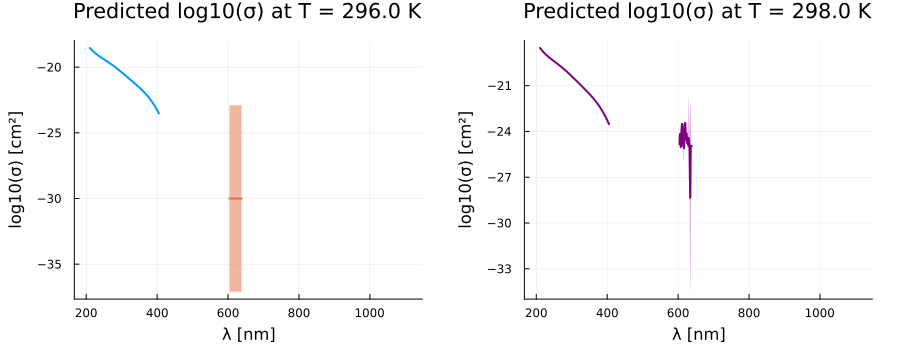

In [85]:

Tplot = 296.0
logσ1, Δlogσ1 = predict_logσ_wΔ(Tplot, hr4000_df, mach1, (λ_min1, λ_max1))
logσ2, Δlogσ2 = predict_logσ_wΔ(Tplot, hr4000_df, mach2, (λ_min2, λ_max2))

p1 = plot(
    hr4000_df.λ, logσ1,
    ribbon= 2 .* Δlogσ1,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)
plot!(
    hr4000_df.λ, logσ2,
    ribbon= 2 .* Δlogσ2,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)


Tplot = 298.0
logσ1, Δlogσ1 = predict_logσ_wΔ(Tplot, hr4000_df, mach1, (λ_min1, λ_max1))
logσ2, Δlogσ2 = predict_logσ_wΔ(Tplot, hr4000_df, mach2, (λ_min2, λ_max2))

p2 = plot(
    hr4000_df.λ, logσ1,
    ribbon= 2 .* Δlogσ1,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot!(
    hr4000_df.λ, logσ2,
    ribbon= 2 .* Δlogσ2,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)


plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [86]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

29×7 DataFrame
 Row │ variable  mean           min      median       max             nmissing ⋯
     │ Symbol    Float64        Float64  Union…       Float64         Int64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         667.499        194.249  672.636      1120.22                0 ⋯
   2 │ σ_1         5.26742e-19    0.0    2.82646e-22     1.17236e-17         0
   3 │ σ_2         5.26742e-19    0.0    2.82646e-22     1.17236e-17         0
   4 │ σ_3         2.15632e-20    0.0    0.0             7.82292e-19         0
   5 │ σ_4         1.25113e-19    0.0    6.4171e-21      6.41009e-19         0 ⋯
   6 │ σ_5         6.58792e-19    0.0    1.71951e-28     1.5094e-17          0
   7 │ σ_6         6.58792e-19    0.0    1.71951e-28     1.5094e-17          0
   8 │ σ_7         8.4788e-20     0.0    0.0             2.33417e-18         0
   9 │ σ_8         8.92125e-20    0.0    0.0             1.11355e-17         0 ⋯
  10 │ σ_11        1.9483e-21     0.0    0.0             9.32842e-20         0
  11 │ σ_12        1.9483e-21     0.0    0.0             9.32842e-20         0
  ⋮  │    ⋮            ⋮           ⋮          ⋮             ⋮            ⋮     ⋱
  20 │ σ_21        2.90646e-21    0.0    0.0             7.47785e-20         0
  21 │ σ_22        1.81346e-21    0.0    0.0             7.83071e-20         0 ⋯
  22 │ σ_23        4.48449e-21    0.0    0.0             6.62263e-20         0
  23 │ σ_24        4.48449e-21    0.0    0.0             6.62263e-20         0
  24 │ σ_31        1.00573e-20    0.0    0.0             4.1655e-19          0
  25 │ σ_32        1.00573e-20    0.0    0.0             4.1655e-19          0 ⋯
  26 │ σ_33        1.00573e-20    0.0    0.0             4.1655e-19          0
  27 │ σ_34        7.33242e-21    0.0    0.0             1.97296e-19         0
  28 │ σ_35        6.1916e-21     0.0    0.0             7.777e-20           0
  29 │ σ_41      NaN            NaN                    NaN                   0 ⋯
                                                     1 column and 8 rows omitted

In [89]:
λ_min = minimum(df.λ)
λ_max = maximum(df.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

210.0	194.249
638.254	1120.216


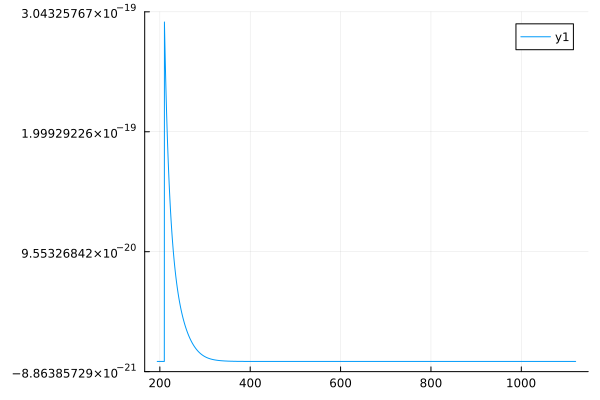

In [94]:
Tplot = 298.0
logσ1, Δlogσ1 = predict_logσ_wΔ(Tplot, hr4000_df, mach1, (λ_min1, λ_max1))
logσ2, Δlogσ2 = predict_logσ_wΔ(Tplot, hr4000_df, mach2, (λ_min2, λ_max2))



σ = 10 .^ logσ1
σ2 = 10 .^ logσ2

# join these two together
for i ∈ 1:length(σ)
    if isnan(σ[i]) && !isnan(σ2[i])
        σ[i] = σ2[i]
    end
end



replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [95]:
df_photolysis_σ.σ_41 = σ

describe(df_photolysis_σ)

29×7 DataFrame
 Row │ variable  mean           min      median         max             nmissi ⋯
     │ Symbol    Float64        Float64  Float64        Float64         Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         667.499        194.249  672.636        1120.22                ⋯
   2 │ σ_1         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   3 │ σ_2         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   4 │ σ_3         2.15632e-20    0.0      0.0             7.82292e-19
   5 │ σ_4         1.25113e-19    0.0      6.4171e-21      6.41009e-19         ⋯
   6 │ σ_5         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   7 │ σ_6         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   8 │ σ_7         8.4788e-20     0.0      0.0             2.33417e-18
   9 │ σ_8         8.92125e-20    0.0      0.0             1.11355e-17         ⋯
  10 │ σ_11        1.9483e-21     0.0      0.0             9.32842e-20
  11 │ σ_12        1.9483e-21     0.0      0.0             9.32842e-20
  ⋮  │    ⋮            ⋮           ⋮           ⋮              ⋮            ⋮   ⋱
  20 │ σ_21        2.90646e-21    0.0      0.0             7.47785e-20
  21 │ σ_22        1.81346e-21    0.0      0.0             7.83071e-20         ⋯
  22 │ σ_23        4.48449e-21    0.0      0.0             6.62263e-20
  23 │ σ_24        4.48449e-21    0.0      0.0             6.62263e-20
  24 │ σ_31        1.00573e-20    0.0      0.0             4.1655e-19
  25 │ σ_32        1.00573e-20    0.0      0.0             4.1655e-19          ⋯
  26 │ σ_33        1.00573e-20    0.0      0.0             4.1655e-19
  27 │ σ_34        7.33242e-21    0.0      0.0             1.97296e-19
  28 │ σ_35        6.1916e-21     0.0      0.0             7.777e-20
  29 │ σ_41        5.69453e-21    0.0      0.0             2.95462e-19         ⋯
                                                    2 columns and 8 rows omitted

In [96]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"